In [1]:
from __future__ import print_function

import gym
import numpy as np
import matplotlib.pyplot as plt

from dnetworks.model import NNet
from dnetworks.layers import LinearLayer, LeakyReLU, MSELoss
from dnetworks.optimizers import Adam
from drlearn import DRLearn
from drlearn.utils import Memory

In [2]:
def play_game(model_rl, n_epochs=10):
    for epoch in range(n_epochs):
        state = model_rl.env.reset()
        total_reward = 0
        while True:
            model_rl.env.render()
            state = state.reshape(model_rl.n_states, 1)
            action = np.argmax(model_rl.model.forward(state).T, axis=1)[0]
            state, reward, done, _ = model_rl.env.step(action)
            total_reward += reward
            if done: break
        print ("%d Reward: %s" % (epoch, total_reward))

    model_rl.env.close()

In [3]:
env_name = 'CartPole-v1'

# Initialize the environment
gym_env = gym.make(env_name)
n_states = gym_env.observation_space.shape[0]
n_actions = gym_env.action_space.n

In [4]:
model = NNet()

# Create the model structure
model.add(LinearLayer(n_states, 64))
model.add(LeakyReLU())

model.add(LinearLayer(64, 32))
model.add(LeakyReLU())

model.add(LinearLayer(32, 8))
model.add(LeakyReLU())

model.add(LinearLayer(8, n_actions))

In [5]:
# set the loss functions and the optimize method
loss = MSELoss()
optim = Adam(lr=0.001)
memory = Memory(capacity=300, sample_size=32)

dqn = DRLearn(
    model=model,
    optim=optim,
    loss=loss,
    env=gym_env,
    memory=memory,
    epsilon=0.9, 
    gamma=0.8, 
    decay_rate=0.005,
    min_epsilon=0.1
)

loss:  0.49106046276252935 max reward:  31.0 epoch:  0
loss:  0.013912252573289985 max reward:  109.0 epoch:  100
loss:  0.013653496731895094 max reward:  212.0 epoch:  200
loss:  0.017644327033831803 max reward:  356.0 epoch:  300
loss:  0.01110703346678944 max reward:  407.0 epoch:  400


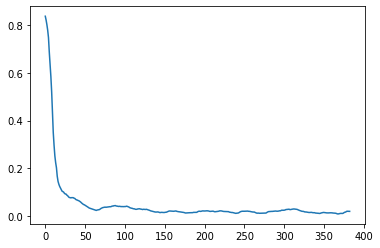

In [6]:
n_epochs = 1000
epoch_losses = []
max_reward = 0

for epoch in range(n_epochs):
    epoch_loss, total_reward = dqn.play()
    max_reward = max(max_reward, total_reward)
    dqn.update_epsilon(epoch=epoch)
    epoch_losses.append(epoch_loss)

    if epoch % 100 == 0:
        print('loss: ', epoch_loss, 'max reward: ', max_reward, 'epoch: ', epoch)
        
    if max_reward == 500:
        break

plt.plot(np.convolve(epoch_losses, np.ones(20), 'valid') / 20)
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


0 Reward: 500.0


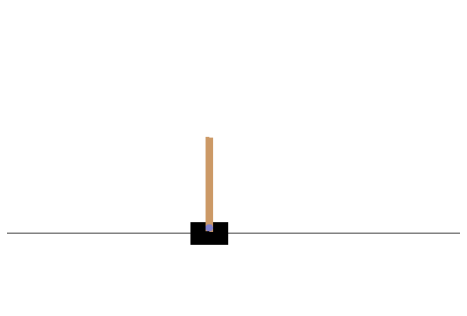

In [13]:
play_game(model_rl=dqn, n_epochs=1)